In [133]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

from skimage.segmentation import clear_border
img = cv.imread('PXL_20210921_095212294.jpg')
img_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [134]:
kernel = np.ones((3,3), np.uint8)

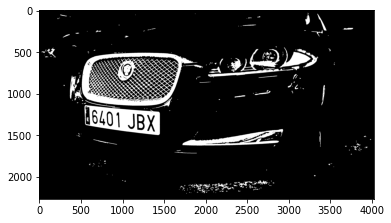

In [135]:
median = cv.medianBlur(img_gris, 3)
ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
edge_touching_removed = clear_border(opening)
contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

plt.imshow(edge_touching_removed, cmap="gray")

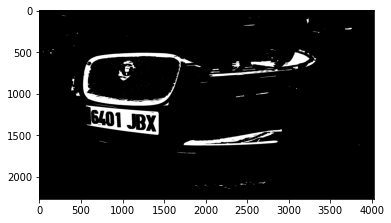

In [136]:
#quitar linias finas elemento que cauan problemas

median = cv.medianBlur(edge_touching_removed, 3)
ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
img_erosion = cv.erode(th, kernel, iterations=4)
opening = cv.morphologyEx(th, cv.MORPH_ERODE,  np.ones((1,30), np.uint8))


plt.imshow(opening, cmap="gray")


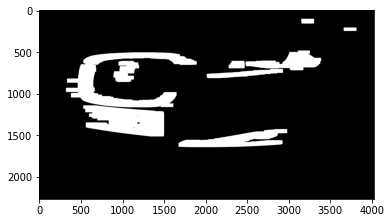

In [137]:
img_erosion = cv.erode(opening, kernel, iterations=7)
img_dilation = cv.dilate(img_erosion, kernel, iterations=7)
img_dilation = cv.dilate(img_dilation, np.ones((2,9), np.uint8), iterations=15)
img_dilation = cv.dilate(img_dilation, kernel, iterations=5)
plt.imshow(img_dilation, cmap="gray")

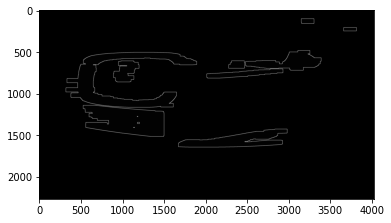

In [138]:
cnts,_=cv.findContours(cv.Canny(img_dilation,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
contornos =  cv.drawContours((img_dilation//255),cnts,-1,(100,100,100),2)
plt.imshow(contornos, cmap="gray")

In [139]:
contornos_millor=cnts[0]
area_max=0
for c in cnts:
    area = cv.contourArea(c)
    if area>area_max:#len(approx)==4 and area>4000:
        area_max=area
        contornos_millor=c
        x_esquerra,y_esquerra,largo,ancho = cv.boundingRect(c)

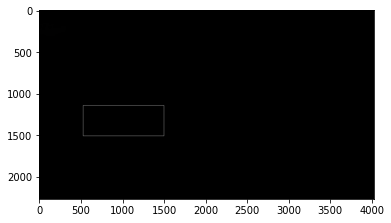

In [140]:
epsilon = 0.02*cv.arcLength(contornos_millor,True)
approx = cv.approxPolyDP(contornos_millor,epsilon,True)
#print(len(approx))
x,y,w,h = cv.boundingRect(approx)

rec = cv.rectangle(img//255,(x,y),(x+w,y+h),(255,255,255),2)
plt.imshow(rec, cmap="gray")

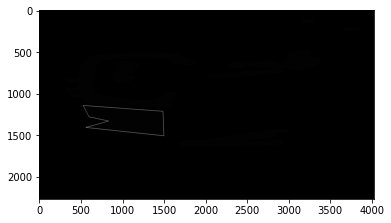

In [141]:
aux=cv.drawContours(img_dilation//255,[approx],0,(100,100,100),2)
plt.imshow(aux, cmap="gray")

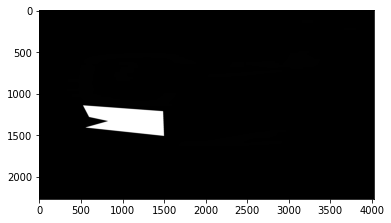

In [142]:
im_floodfill = ((aux>2) * aux).copy()
 
h, w = aux.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv.floodFill(im_floodfill, mask, (0,0), 255)
 
# Invert floodfilled image
im_floodfill_inv = cv.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = aux | im_floodfill_inv
 
plt.imshow( im_out,cmap="gray")

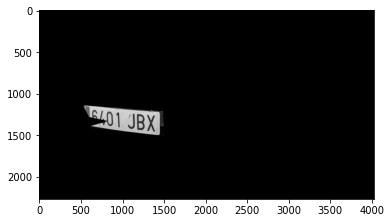

In [143]:
imagen_final=img_gris*(im_out>200)
plt.imshow(imagen_final,cmap="gray")

In [144]:
#plt.imshow(imagen_final[y_esquerra:y_esquerra+ancho,x_esquerra:x_esquerra+largo],cmap="gray")

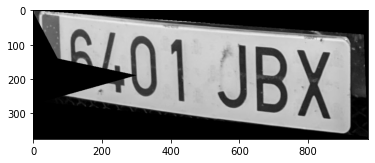

In [145]:
imagen_recortada=imagen_final[y_esquerra:y_esquerra+ancho,x_esquerra:x_esquerra+largo]
plt.imshow(imagen_recortada,cmap="gray")

https://es.stackoverflow.com/questions/141818/como-enderezo-una-imagen-en-python

https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/

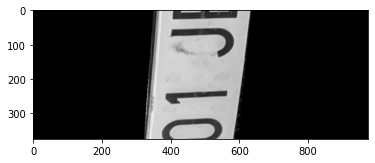

In [154]:

gray = cv.bitwise_not(imagen_recortada)
thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

plt.imshow(gray,cmap="gray")

coords = np.column_stack(np.where(thresh > 0))
angle = cv.minAreaRect(coords)[-1]



if angle <- 45:
	angle =  (-90 + angle)


else:
	angle = -angle

(h, w) = imagen_recortada.shape[:2]
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, -angle, 1.0)
rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
 
plt.imshow(rotated,cmap="gray")


In [147]:
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

In [148]:
text = pytesseract.image_to_string(imagen_recortada,config='--psm 11')
print('PLACA: ',text)

PLACA:  U1 JBX



In [149]:
#solo funciono si detecta todos los elementos de la maricula, elimina los resultados incorecots que
#no son parte de la matricula pero por estar de fondo en la imgen el ocr lo detecta com un caracter
#elimina gran parte de estos caracterres erroneos

count = 0
ll = list(text.lower())
if ' ' in  ll:
    ll.remove(" ")
matricula = ""
for letra in ll:
    if count < 4:
        if letra in ("1234567890"):
            count += 1
            matricula += letra
        else:
            count = 0
    else:
        if letra in ("qwertyuuiopasdfghjklñzxcvbnm"):
            count += 1
            matricula += letra.upper()

print(matricula)

1
